In [1]:
import pandas as pd
import re
import ast

# Load the CSV file
csv_file = pd.read_csv('data_with_smiles.csv')

# Define a function to expand rows by tests
def expand_rows_by_tests(df):
    # Create a list to store the expanded rows
    expanded_rows = []
    
    # Iterate through each row in the dataframe
    for _, row in df.iterrows():
        # Iterate through test columns
        for i in range(1, 11):  # Assuming test_1 to test_10
            test_column = f'test_{i}'
            test_data = row[test_column]
            if pd.notnull(test_data):
                try:
                    test_list = ast.literal_eval(test_data)
                    if isinstance(test_list, dict):
                        test_list = [test_list]
                    for test_dict in test_list:
                        new_row = row.drop([f'test_{j}' for j in range(1, 11)])
                        # Add test details to the new row
                        for key, value in test_dict.items():
                            new_row[key] = value
                        expanded_rows.append(new_row)
                except (ValueError, SyntaxError):
                    print(f"Could not parse test data: {test_data}")

    # Create a new dataframe from the expanded rows
    expanded_df = pd.DataFrame(expanded_rows)
    return expanded_df

# Apply the function to expand the rows
expanded_df = expand_rows_by_tests(csv_file)

In [2]:
def fix_retained_percentage(test_data):
    cont_key = 'retained_percentage_cont'
    tret_key = 'retained_percentage_tret'
    cont = test_data[cont_key] if cont_key in test_data else None 
    tret = test_data[tret_key] if tret_key in test_data else None
    if cont is not None and tret is None:
        test_data['retained_percentage_tret'] = cont
        test_data['retained_percentage_cont'] = None
    return test_data

expanded_df = fix_retained_percentage(expanded_df)

In [3]:
df = expanded_df.copy()

df = df[[
    'perovskite_composition', 'electron_transport_layer', 'hole_transport_layer', 'pin_nip_structure',
    'passivating_molecule', 'control_pce', 'control_voc', 'treated_pce', 'treated_voc', 'passivator_smiles', 'time', 
    'retained_percentage_tret'
]]
df['pce_percent_change'] = ((df['treated_pce'] - df['control_pce']) / df['control_pce']) * 100

# If it uses C60 as its electron_transport_layer
df['C60'] = (df['electron_transport_layer'] == 'C60')

# if it uses Spiro-OMeTAD as its hole_transport_layer
df['Spiro-OMeTAD'] = (df['hole_transport_layer'] == 'Spiro-OMeTAD')

df.head()

,perovskite_composition,electron_transport_layer,hole_transport_layer,pin_nip_structure,passivating_molecule,control_pce,control_voc,treated_pce,treated_voc,passivator_smiles,time,retained_percentage_tret,pce_percent_change,C60,Spiro-OMeTAD
0,MAPbI3,PEDOT:PSS,PCBM,NIP,DAAB,4.50,0.87,12.60,0.92,N(=NC1=CC=CC=C1)C1=CC=CC=C1.[NH4+].[NH4+],1000,68,180.000000,False,False
0,MAPbI3,PEDOT:PSS,PCBM,NIP,DAAB,4.50,0.87,12.60,0.92,N(=NC1=CC=CC=C1)C1=CC=CC=C1.[NH4+].[NH4+],1000,50,180.000000,False,False
1,Cs 0.05 FA 0.9 MA 0.05 PbI 3,NaN,NaN,NaN,Cyanoguanidine diiodide,20.44,1077.00,23.04,1119.00,[I-].[I-].C(#N)NC(=N)N,60,83,12.720157,False,False
4,NaN,NaN,NaN,NaN,2-Mercaptopyrimidine,NaN,NaN,21.70,1.12,SC1=NC=CC=N1,97,90.0,NaN,False,False
6,FA 0.6 MA 0.4 PbI2.7 Cl0.3,SnO2,Spiro-OMeTAD,NIP,4-chlorobenzylammonium chloride (75%) and 4-ch...,18.31,1.06,21.00,1.12,[Cl-].ClC1=CC=C(C[NH3+])C=C1,672,88,14.691425,False,True


In [4]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

def compute_molecular_features(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return [
                Descriptors.MolWt(mol),  # Molecular weight
                Descriptors.ExactMolWt(mol),  # Exact molecular weight (isotope-specific)
                Descriptors.MolLogP(mol),  # LogP (lipophilicity)
                Descriptors.TPSA(mol),  # Topological Polar Surface Area
                Descriptors.NumValenceElectrons(mol),  # Total valence electrons
                rdMolDescriptors.CalcNumRotatableBonds(mol),  # Rotatable bonds
                rdMolDescriptors.CalcNumHBA(mol),  # Hydrogen bond acceptors
                rdMolDescriptors.CalcNumHBD(mol),  # Hydrogen bond donors
                rdMolDescriptors.CalcFractionCSP3(mol),  # Fraction of sp3 carbons
                rdMolDescriptors.CalcNumAromaticRings(mol),  # Number of aromatic rings
                rdMolDescriptors.CalcNumSaturatedRings(mol),  # Number of saturated rings
                rdMolDescriptors.CalcNumHeteroatoms(mol),  # Number of heteroatoms
                rdMolDescriptors.CalcNumHeavyAtoms(mol),  # Number of heavy atoms
                rdMolDescriptors.CalcNumSpiroAtoms(mol),  # Number of spiro atoms
                rdMolDescriptors.CalcNumBridgeheadAtoms(mol),  # Number of bridgehead atoms
                Descriptors.FpDensityMorgan1(mol),  # Morgan fingerprint density (radius=1)
                Descriptors.FpDensityMorgan2(mol),  # Morgan fingerprint density (radius=2)
                Descriptors.FpDensityMorgan3(mol),  # Morgan fingerprint density (radius=3)
                Descriptors.qed(mol),  # Quantitative Estimate of Drug-likeness
                rdMolDescriptors.CalcNumLipinskiHBA(mol),  # Lipinski Hydrogen Bond Acceptors
                rdMolDescriptors.CalcNumLipinskiHBD(mol),  # Lipinski Hydrogen Bond Donors
                rdMolDescriptors.CalcNumRings(mol),  # Total number of rings
                rdMolDescriptors.CalcNumAmideBonds(mol),  # Number of amide bonds
                Descriptors.BalabanJ(mol),  # Balaban’s connectivity index
                Descriptors.BertzCT(mol),  # Bertz complexity
                Descriptors.Chi0(mol),  # Chi connectivity index (order 0)
                Descriptors.Chi1(mol),  # Chi connectivity index (order 1)
                Descriptors.Chi2n(mol),  # Chi connectivity index (order 2, non-H)
                Descriptors.Kappa1(mol),  # Kappa Shape Index (order 1)
                Descriptors.Kappa2(mol),  # Kappa Shape Index (order 2)
            ]
        else:
            return [np.nan] * 30  # Return NaN for missing values
    except:
        return [np.nan] * 30  # Return NaN for exceptions

In [5]:
# Apply function to dataset
mol_features = df['passivator_smiles'].apply(compute_molecular_features)

# Convert list to DataFrame
mol_features_df = pd.DataFrame(mol_features.tolist(), 
                               columns=[
                                   'MolWt', 'ExactMolWt', 'LogP', 'TPSA', 'NumValenceElectrons',
                                   'NumRotBonds', 'NumHBA', 'NumHBD', 'FractionCSP3', 'AromaticRings',
                                   'SaturatedRings', 'Heteroatoms', 'HeavyAtoms', 'SpiroAtoms', 
                                   'BridgeheadAtoms', 'FpDensityMorgan1', 'FpDensityMorgan2', 
                                   'FpDensityMorgan3', 'QED', 'LipinskiHBA', 
                                   'LipinskiHBD', 'NumRings', 'NumAmideBonds', 'BalabanJ', 
                                   'BertzCT', 'Chi0', 'Chi1', 'Chi2n', 'Kappa1', 'Kappa2'
                               ],
                               index=df.index)

# Merge with original dataset
df = pd.concat([df, mol_features_df], axis=1)
df = df.dropna(subset=['passivator_smiles'])

[16:47:47] WARNING: not removing hydrogen atom without neighbors
[16:47:47] WARNING: not removing hydrogen atom without neighbors
[16:47:48] WARNING: not removing hydrogen atom without neighbors
[16:47:48] WARNING: not removing hydrogen atom without neighbors
[16:47:48] Explicit valence for atom # 25 C, 5, is greater than permitted
[16:47:48] WARNING: not removing hydrogen atom without neighbors
[16:47:48] WARNING: not removing hydrogen atom without neighbors
[16:47:48] WARNING: not removing hydrogen atom without neighbors
[16:47:48] WARNING: not removing hydrogen atom without neighbors


In [6]:
def clean_pin_nip_structure(df, column_name='pin_nip_structure'):
    # Define a mapping for known categories
    mapping = {
        'NIP': 'NIP',
        'PIN': 'PIN',
        'n-i-p': 'NIP',
        'p-i-n': 'PIN',
        'Inverted': 'PIN',
        'pin': 'PIN',
        'ITO/SnO2/perovskite/Spiro-OMeTAD/Ag': 'NIP'
    }
    
    # Apply the mapping and fill unknowns with 'Other'
    df[column_name] = df[column_name].map(mapping).fillna('Other')
    
    return df

clean_pin_nip_structure(df);

In [7]:
def parse_perovskite_formula(formula):
    # Define allowed species (order matters for multi-letter elements)
    allowed_species = ["FA", "MA", "CS", "Rb", "Pb", "Sn", "I", "Br", "Cl"]

    # if is the nan we return component dictionary with all zeros
    if formula is np.nan:
        formula = ""    
    
    # Dictionary to store parsed results (initialize with 0.0 for all species)
    parsed_result = {species: 0.0 for species in allowed_species}

    # Step 1: Handle groups in parentheses with coefficients (e.g., (FAPbI3)0.95)
    pattern_group = r"\(([^)]+)\)\s*([0-9\.]+)"

    
    
    groups = re.findall(pattern_group, formula)

    if groups:
        for group, coef in groups:
            coef = float(coef)  # Convert coefficient to float
            elements = re.findall(r"(FA|MA|CS|Rb|Pb|Sn|I|Br|Cl)\s*([\d\.]*)", group)
            for element, count in elements:
                count = float(count) if count else 1.0
                parsed_result[element] += count * coef  # Distribute coefficient

    # Step 2: Handle formulas without parentheses (e.g., FA1-xMAxPbI3)
    remaining_formula = re.sub(r"\([^)]*\)\s*[0-9\.]+", "", formula)  # Remove processed groups
    elements = re.findall(r"(FA|MA|CS|Rb|Pb|Sn|I|Br|Cl)\s*([\d\.]*)", remaining_formula)

    for element, count in elements:
        count = float(count) if count and 'x' not in count else 1.0  # Ignore '-x' or 'x'
        parsed_result[element] += count

    # Round to 2 decimal places for all values
    parsed_result = {k: round(v, 2) for k, v in parsed_result.items()}

    return parsed_result

# # Test cases
# formulas = [
#     "(FAPbI3)0.95(MAPbBr3)0.05",
#     "FA1-xMAxPbI3",
#     "FA0.9CS0.1Rb0.05PbI2.9Br0.1",
#     "(CS0.8Rb0.2FAPbI3)0.9(MAPbBr3)0.1",
#     "(C4H9NH3)2PbI 4" # Test case with space
# ]

# for formula in formulas:
#     print(f"Formula: {formula}")
#     print("Parsed:", parse_perovskite_formula(formula))
#     print()

In [8]:
temp = df['perovskite_composition'].apply(parse_perovskite_formula).apply(pd.Series)
df = pd.concat([df, temp], axis=1)

In [9]:
df = df.dropna(subset=['NumRotBonds', 'treated_pce', 'control_pce', 'control_voc', 'treated_voc'])
df = df[df['treated_pce'] > 10]
df = df[df['treated_pce'] <= 35]
df = df[df['control_pce'] > 10]
df = df[df['control_pce'] <= 35]
df = df[df['pce_percent_change'] <= 35]
df = df[df['control_pce'] <= 35]

In [10]:
# Define feature columns
categorical_features = ['pin_nip_structure']
numerical_features = ['control_voc', 'C60', 'Spiro-OMeTAD']
smiles_features=[
                                   'MolWt', 'ExactMolWt', 'LogP', 'TPSA', 'NumValenceElectrons',
                                   'NumRotBonds', 'NumHBA', 'NumHBD', 'FractionCSP3', 'AromaticRings',
                                   'SaturatedRings', 'Heteroatoms', 'HeavyAtoms', 'SpiroAtoms', 
                                   'BridgeheadAtoms', 'FpDensityMorgan1', 'FpDensityMorgan2', 
                                   'FpDensityMorgan3', 'QED', 'LipinskiHBA', 
                                   'LipinskiHBD', 'NumRings', 'NumAmideBonds', 'BalabanJ', 
                                   'BertzCT', 'Chi0', 'Chi1', 'Chi2n', 'Kappa1', 'Kappa2'
                               ]
composition_feature = ['FA', 'MA','CS', 'Rb', 'Pb', 'Sn', 'I', 'Br', 'Cl']
other = ['control_pce']

include_columns = categorical_features + smiles_features + composition_feature + other

target_column = 'pce_percent_change'

In [11]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# Store performance metrics for each model and each random seed
model_performance = []

# Drop rows with missing values in both features and target column
data_clean = df.dropna(subset=[target_column] + include_columns)
data_clean.to_csv('df_prediction_1.csv')

# Prepare features and target again
X = data_clean.drop(columns=[target_column])[include_columns]
y = data_clean[target_column]

def get_models(random_state):
    return {
        'Random Forest': RandomForestRegressor(random_state=random_state),
        'Linear Regression': LinearRegression(),
        'Support Vector Regressor': SVR(),
        'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
        'AdaBoost': AdaBoostRegressor(random_state=random_state)
    }

random_seeds = random.sample(range(0, 1000), 50)

# Iterate over multiple random seeds
for seed in random_seeds:
    # Split the data into training and testing sets with the current random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # One-hot encode categorical variables, ensuring consistent columns
    X_train = pd.get_dummies(X_train, columns=['pin_nip_structure'], drop_first=False)
    X_test = pd.get_dummies(X_test, columns=['pin_nip_structure'], drop_first=False)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    
    models = get_models(42)
    for name, model in models.items():
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        # Store metrics with random seed info
        model_performance.append({
            'Model': name,
            'Seed': seed,
            'R2': r2,
            'MAE': mae,
            'MSE': mse
        })

# Convert to DataFrame
performance_df = pd.DataFrame(model_performance)

# Calculate average performance across random seeds
average_performance = performance_df.groupby('Model').agg({
    'R2': 'mean',
    'MAE': 'mean',
    'MSE': 'mean'
}).reset_index()

# Sort models by average R2 performance
average_performance = average_performance.sort_values(by='R2', ascending=False)
print(average_performance)

                      Model        R2       MAE        MSE
3             Random Forest  0.484417  2.982250  23.675517
0                  AdaBoost  0.311003  4.052864  31.353892
2         Linear Regression  0.210307  4.278765  35.714466
1       K-Nearest Neighbors  0.040385  4.770051  43.823345
4  Support Vector Regressor -0.017929  4.879733  46.769992


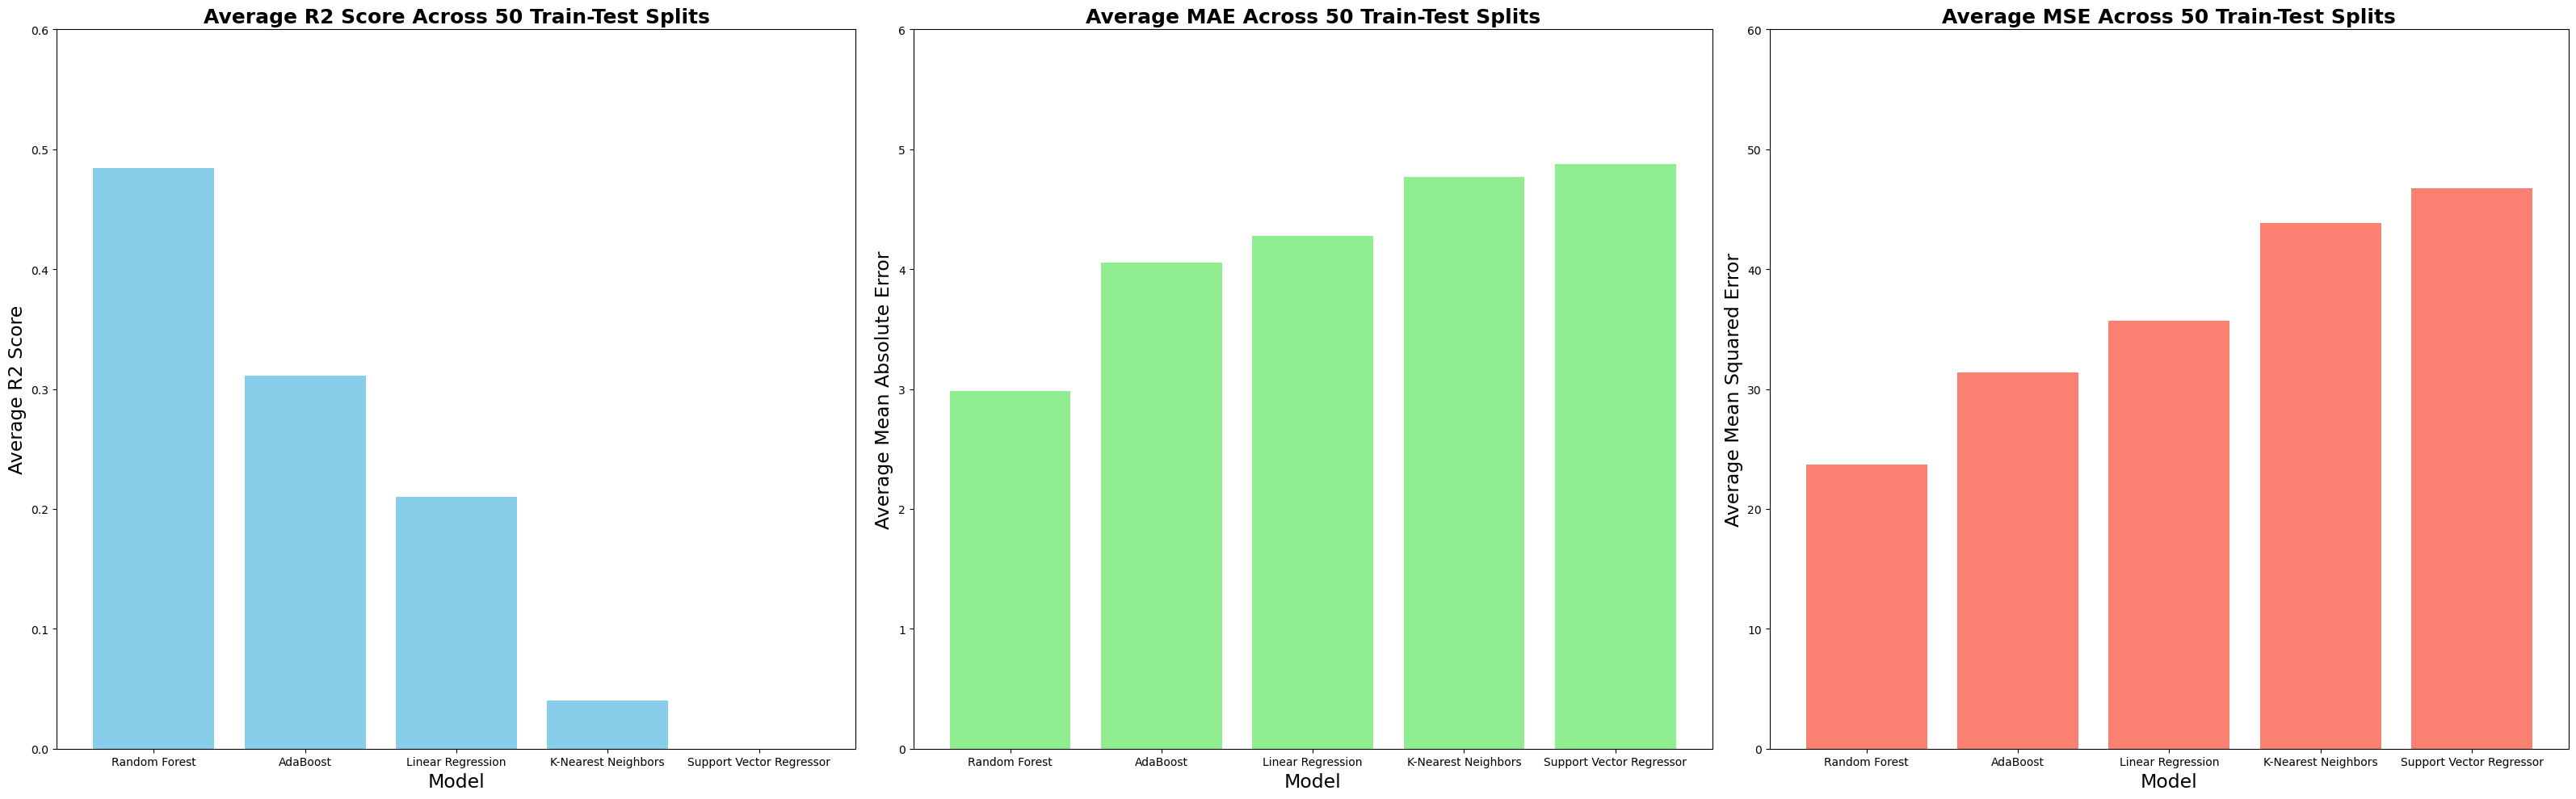

In [12]:
import numpy as np

# Helper function to get a "nice" tick increment
def get_nice_tick_interval(max_value, num_ticks=10):
    raw_interval = max_value / num_ticks
    magnitude = 10 ** np.floor(np.log10(raw_interval))  # Get order of magnitude
    nice_intervals = np.array([1, 2, 5, 10]) * magnitude  # Possible nice intervals
    interval = nice_intervals[nice_intervals >= raw_interval].min()  # Smallest nice interval
    return interval

# Set negative R2 scores to zero for visualization
average_performance['R2'] = average_performance['R2'].apply(lambda x: max(0, x))

# Plotting the average performance of each model
fig, axes = plt.subplots(1, 3, figsize=(32, 10))

# R2 Score
r2_max = max(average_performance['R2']) * 1.1
r2_tick_step = get_nice_tick_interval(r2_max)
r2_max = np.ceil(r2_max / r2_tick_step) * r2_tick_step

axes[0].bar(average_performance['Model'], average_performance['R2'], color='skyblue')
axes[0].set_title('Average R2 Score Across 50 Train-Test Splits', fontsize=18, fontweight='bold')
axes[0].set_xlabel('Model', fontsize=17)
axes[0].set_ylabel('Average R2 Score', fontsize=17)
axes[0].set_ylim([0, r2_max])
axes[0].set_yticks(np.arange(0, r2_max + r2_tick_step, r2_tick_step))

# MAE
mae_max = max(average_performance['MAE']) * 1.1
mae_tick_step = get_nice_tick_interval(mae_max)
mae_max = np.ceil(mae_max / mae_tick_step) * mae_tick_step

axes[1].bar(average_performance['Model'], average_performance['MAE'], color='lightgreen')
axes[1].set_title('Average MAE Across 50 Train-Test Splits', fontsize=18, fontweight='bold')
axes[1].set_xlabel('Model', fontsize=17)
axes[1].set_ylabel('Average Mean Absolute Error', fontsize=17)
axes[1].set_ylim([0, mae_max])
axes[1].set_yticks(np.arange(0, mae_max + mae_tick_step, mae_tick_step))

# MSE
mse_max = max(average_performance['MSE']) * 1.1
mse_tick_step = get_nice_tick_interval(mse_max)
mse_max = np.ceil(mse_max / mse_tick_step) * mse_tick_step

axes[2].bar(average_performance['Model'], average_performance['MSE'], color='salmon')
axes[2].set_title('Average MSE Across 50 Train-Test Splits', fontsize=18, fontweight='bold')
axes[2].set_xlabel('Model', fontsize=17)
axes[2].set_ylabel('Average Mean Squared Error', fontsize=17)
axes[2].set_ylim([0, mse_max])
axes[2].set_yticks(np.arange(0, mse_max + mse_tick_step, mse_tick_step))

plt.tight_layout()
plt.savefig('avg_across_50_split.png', dpi=200)
plt.show()

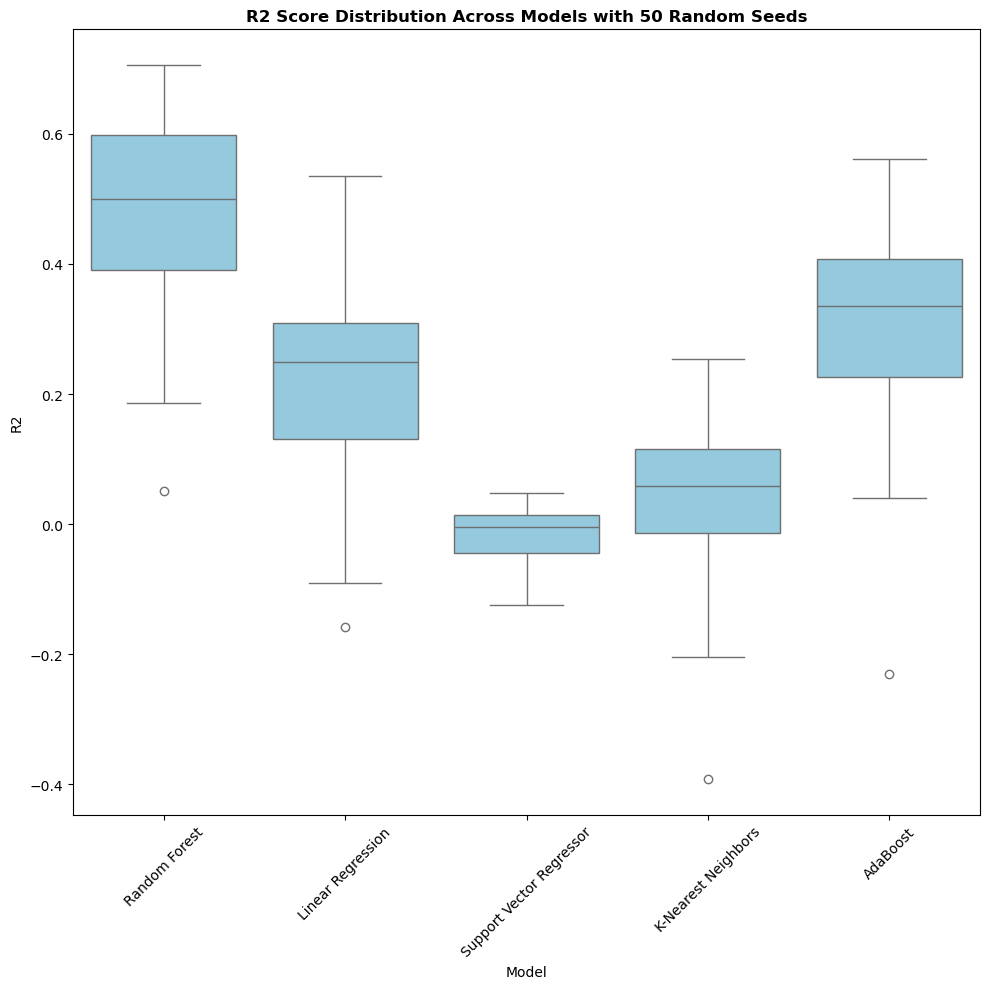

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.boxplot(data=performance_df, x='Model', y='R2', color='skyblue')
plt.xticks(rotation=45)
plt.title('R2 Score Distribution Across Models with 50 Random Seeds', fontweight='bold')

# Adjust layout to prevent clipping
plt.tight_layout()

# Save the figure with adjusted layout
plt.savefig('r2_score_dist.png', dpi=200)

plt.show()

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
from sklearn.model_selection import train_test_split

# Drop rows with missing values in both features and target column
data_clean = df.dropna(subset=[target_column] + include_columns)
data_clean.to_csv('df_prediction_1.csv')

# Prepare features and target again
X = data_clean.drop(columns=[target_column])[include_columns]
y = data_clean[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = pd.get_dummies(X_train, columns=['pin_nip_structure'], drop_first=False)
X_test = pd.get_dummies(X_test, columns=['pin_nip_structure'], drop_first=False)
# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Prepare results for display
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

mse, r2, mae

(15.807555441162398, 0.6325602745000569, 2.884223494311897)

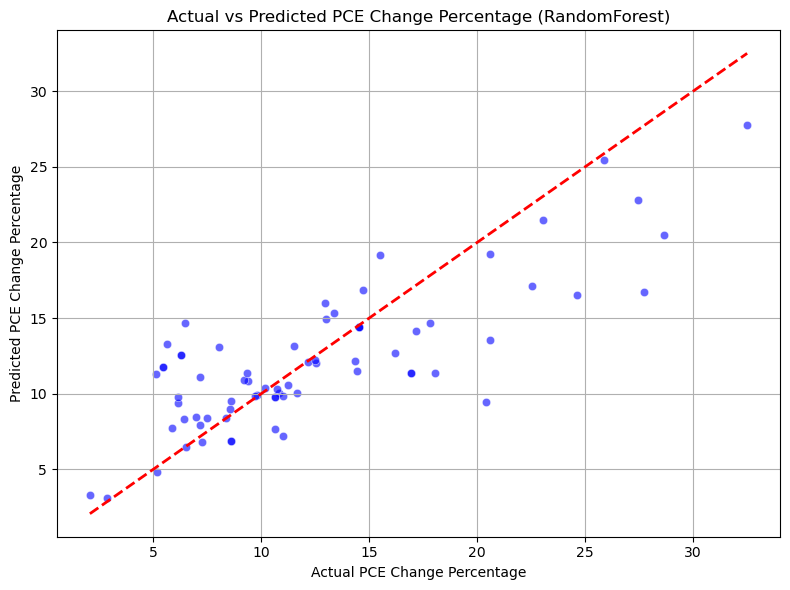

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, color='red')
plt.xlabel('Actual PCE Change Percentage')
plt.ylabel('Predicted PCE Change Percentage')
plt.title('Actual vs Predicted PCE Change Percentage (RandomForest)')
plt.grid(True)
plt.tight_layout()
plt.savefig('RF_actual_vs_predicted.png',dpi=300)
plt.show()

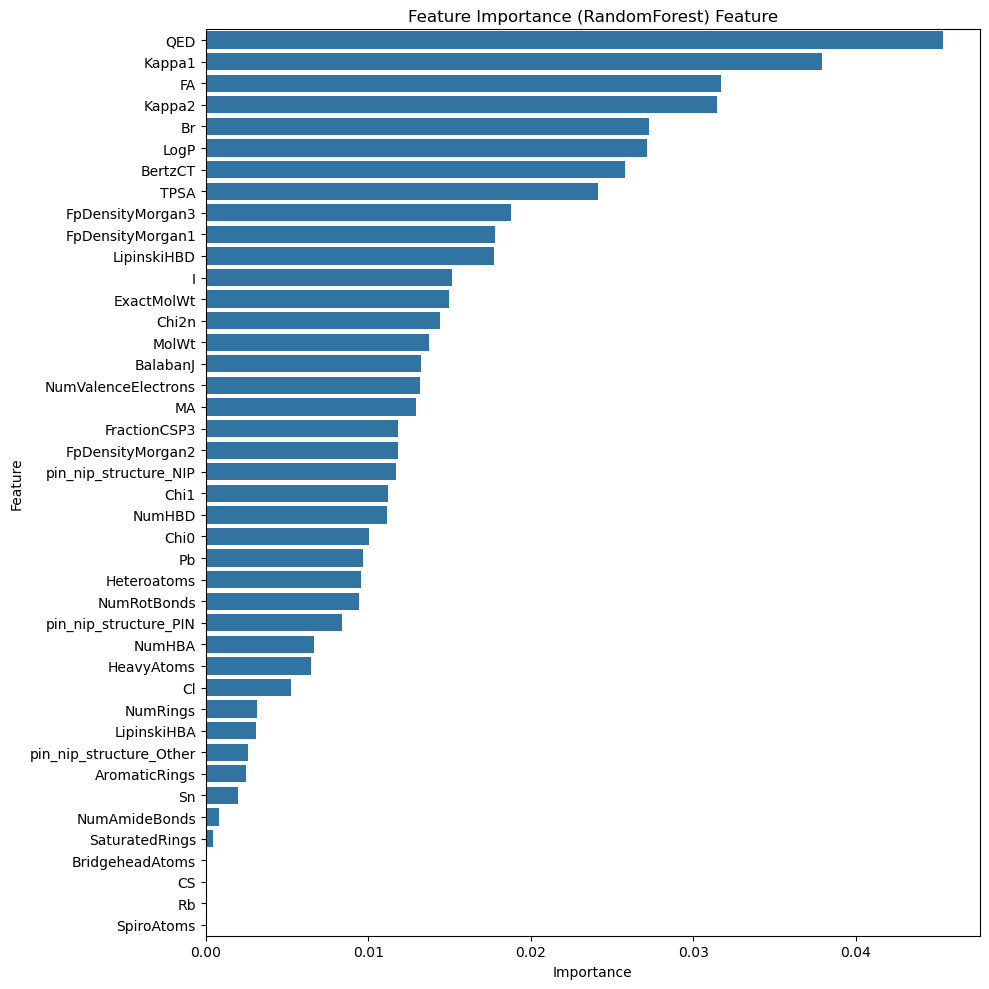

In [16]:
# Calculate feature importances
feature_importances = model.feature_importances_
features = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Exclude the most important feature
importance_df_excluded = importance_df.iloc[1:]  # Skip the first row (most important feature)

# Plot feature importances without the most important feature
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df_excluded)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (RandomForest) Feature')
plt.tight_layout()
plt.savefig('RF_feature_importance.png', dpi=300)
plt.show()